## - IMPORT LIBRAIRIES

In [1]:
%matplotlib notebook

import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt

from pyunlocbox import functions, solvers
import pandas as pd
import networkx as nx

## - LOAD ADJACENCY

In [2]:
adjacency = np.load('adjacency.npy')
n_nodes = np.size(adjacency,1) # the number of nodes in the network
n_edges = sum(sum(adjacency!=0))/2 # number of edges in the network
degrees = sum(adjacency!=0)

## - GRAPH COMPUTING

In [3]:
G = nx.Graph()
G = nx.from_numpy_matrix(adjacency)

## - LAYOUT CHOICE

In [4]:
pos = nx.spring_layout(G)

## - GRAPH VISUALIZATION

<IPython.core.display.Javascript object>


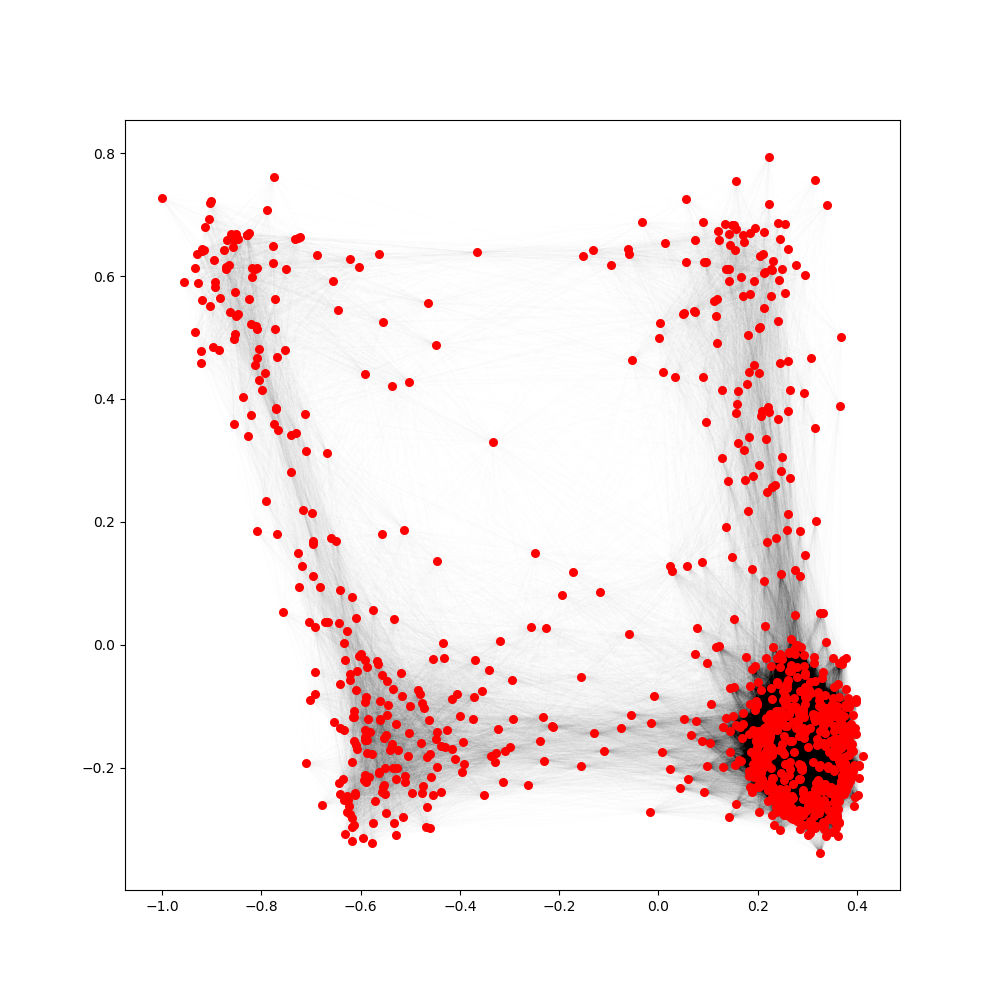

C:\Users\vndk36\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [5]:
plt.figure(figsize = (10,10))
nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_edges(G, pos, alpha =0.005)

## - NODE SELECTION

<IPython.core.display.Javascript object>


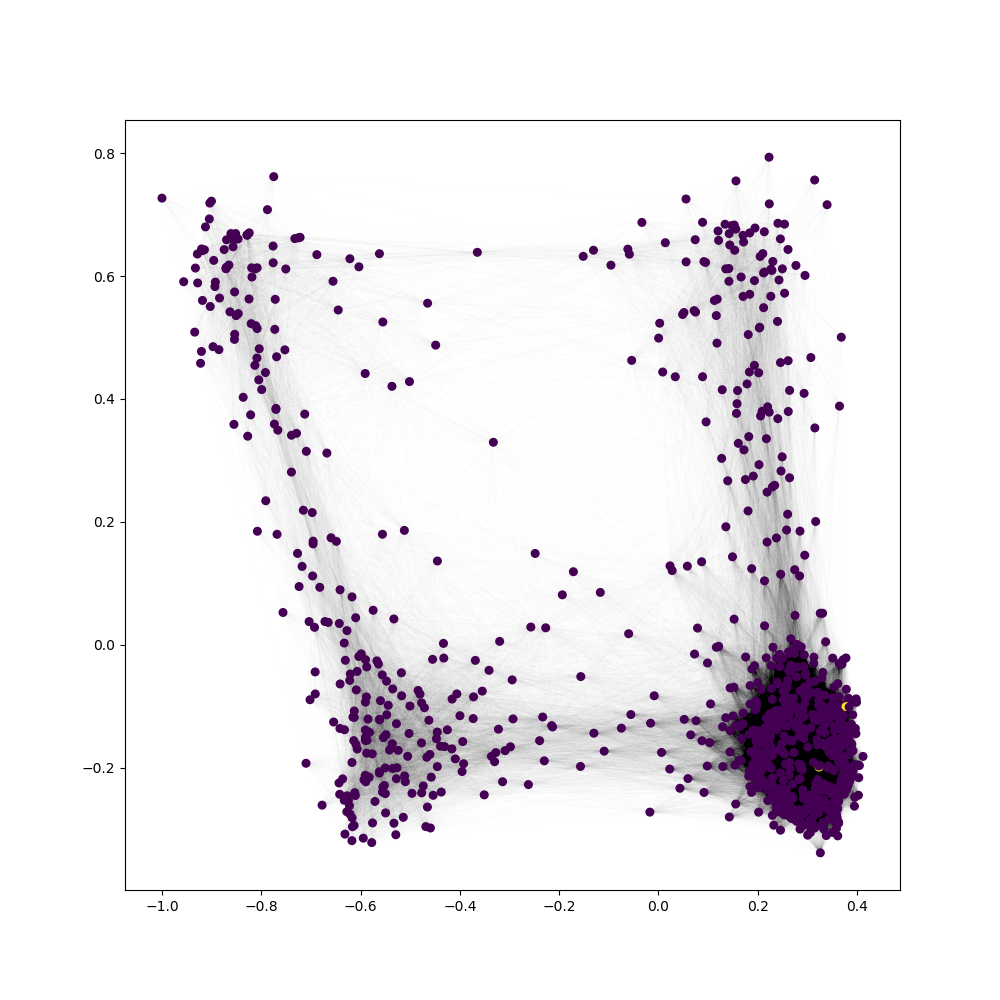

In [6]:
selected_nodes = [400, 800]
max_length = 2

color = np.ones((n_nodes))
color[selected_nodes] = 5
plt.figure(figsize = (10,10))
nx.draw_networkx_nodes(G, pos, node_size=30, node_color=color)
nx.draw_networkx_edges(G, pos, alpha =0.005)

## - COMPUTE PATHS

In [7]:
paths = nx.all_simple_paths(G, selected_nodes[0], selected_nodes[1], max_length)
list_paths = list(paths)
list_paths

[[400, 0, 800],
 [400, 1, 800],
 [400, 6, 800],
 [400, 11, 800],
 [400, 15, 800],
 [400, 17, 800],
 [400, 23, 800],
 [400, 24, 800],
 [400, 25, 800],
 [400, 26, 800],
 [400, 29, 800],
 [400, 34, 800],
 [400, 35, 800],
 [400, 36, 800],
 [400, 37, 800],
 [400, 38, 800],
 [400, 39, 800],
 [400, 40, 800],
 [400, 41, 800],
 [400, 42, 800],
 [400, 43, 800],
 [400, 45, 800],
 [400, 49, 800],
 [400, 59, 800],
 [400, 60, 800],
 [400, 63, 800],
 [400, 78, 800],
 [400, 80, 800],
 [400, 82, 800],
 [400, 92, 800],
 [400, 95, 800],
 [400, 96, 800],
 [400, 97, 800],
 [400, 102, 800],
 [400, 105, 800],
 [400, 109, 800],
 [400, 111, 800],
 [400, 112, 800],
 [400, 132, 800],
 [400, 145, 800],
 [400, 147, 800],
 [400, 148, 800],
 [400, 155, 800],
 [400, 160, 800],
 [400, 163, 800],
 [400, 171, 800],
 [400, 174, 800],
 [400, 175, 800],
 [400, 176, 800],
 [400, 189, 800],
 [400, 193, 800],
 [400, 194, 800],
 [400, 198, 800],
 [400, 202, 800],
 [400, 207, 800],
 [400, 210, 800],
 [400, 224, 800],
 [400, 232

## - COMPUTE SMOOTHNESS

The smoothness of a signal can be computed by the quadratic form

$$ f^\intercal L f = \| \nabla_\mathcal{G} f \|_2^2 = \sum_{i \sim j} W_{ij} (f_j - f_i)^2 $$

In [8]:
import pylab
import math

class AnnoteFinder(object):
    """callback for matplotlib to display an annotation when points are
    clicked on.  The point which is closest to the click and within
    xtol and ytol is identified.
    
    Register this function like this:
    
    scatter(xdata, ydata)
    af = AnnoteFinder(xdata, ydata, annotes)
    connect('button_press_event', af)
    """

    def __init__(self, xdata, ydata, annotes, ax=None, xtol=None, ytol=None):
        self.data = list(zip(xdata, ydata, annotes))
        if xtol is None:
            xtol = ((max(xdata) - min(xdata))/float(len(xdata)))/2
        if ytol is None:
            ytol = ((max(ydata) - min(ydata))/float(len(ydata)))/2
        self.xtol = xtol
        self.ytol = ytol
        if ax is None:
            self.ax = plt.gca()
        else:
            self.ax = ax
        self.drawnAnnotations = {}
        self.links = []

    def distance(self, x1, x2, y1, y2):
        """
        return the distance between two points
        """
        return(math.sqrt((x1 - x2)**2 + (y1 - y2)**2))

    def __call__(self, event):

        if event.inaxes:

            clickX = event.xdata
            clickY = event.ydata
            if (self.ax is None) or (self.ax is event.inaxes):
                annotes = []
                # print(event.xdata, event.ydata)
                for x, y, a in self.data:
                    # print(x, y, a)
                    if ((clickX-self.xtol < x < clickX+self.xtol) and
                            (clickY-self.ytol < y < clickY+self.ytol)):
                        annotes.append(
                            (self.distance(x, clickX, y, clickY), x, y, a))
                if annotes:
                    annotes.sort()
                    distance, x, y, annote = annotes[0]
                    self.drawAnnote(event.inaxes, x, y, annote)
                    for l in self.links:
                        l.drawSpecificAnnote(annote)

    def drawAnnote(self, ax, x, y, annote):
        """
        Draw the annotation on the plot
        """
        if (x, y) in self.drawnAnnotations:
            markers = self.drawnAnnotations[(x, y)]
            for m in markers:
                m.set_visible(not m.get_visible())
            self.ax.figure.canvas.draw_idle()
        else:
            t = ax.text(x, y, " - %s" % (annote),)
            m = ax.scatter([x], [y], marker='d', c='r', zorder=100)
            self.drawnAnnotations[(x, y)] = (t, m)
            self.ax.figure.canvas.draw_idle()

    def drawSpecificAnnote(self, annote):
        annotesToDraw = [(x, y, a) for x, y, a in self.data if a == annote]
        for x, y, a in annotesToDraw:
            self.drawAnnote(self.ax, x, y, a)

<IPython.core.display.Javascript object>


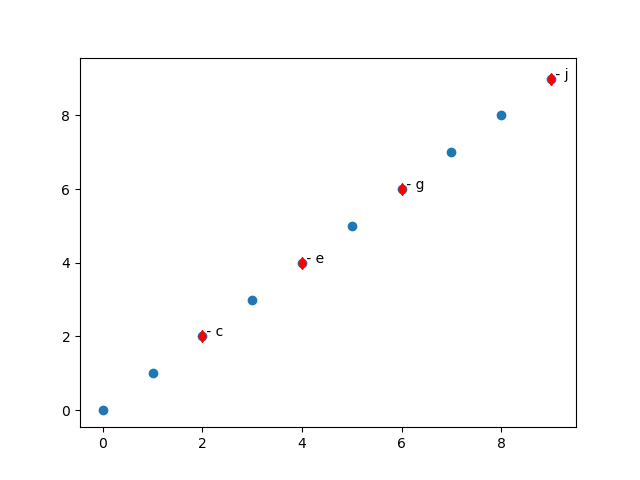

In [9]:
x = range(10)
y = range(10)
annotes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

fig, ax = plt.subplots()
ax.scatter(x,y)
af =  AnnoteFinder(x,y, annotes, ax=ax)
fig.canvas.mpl_connect('button_press_event', af)
plt.show()

<IPython.core.display.Javascript object>


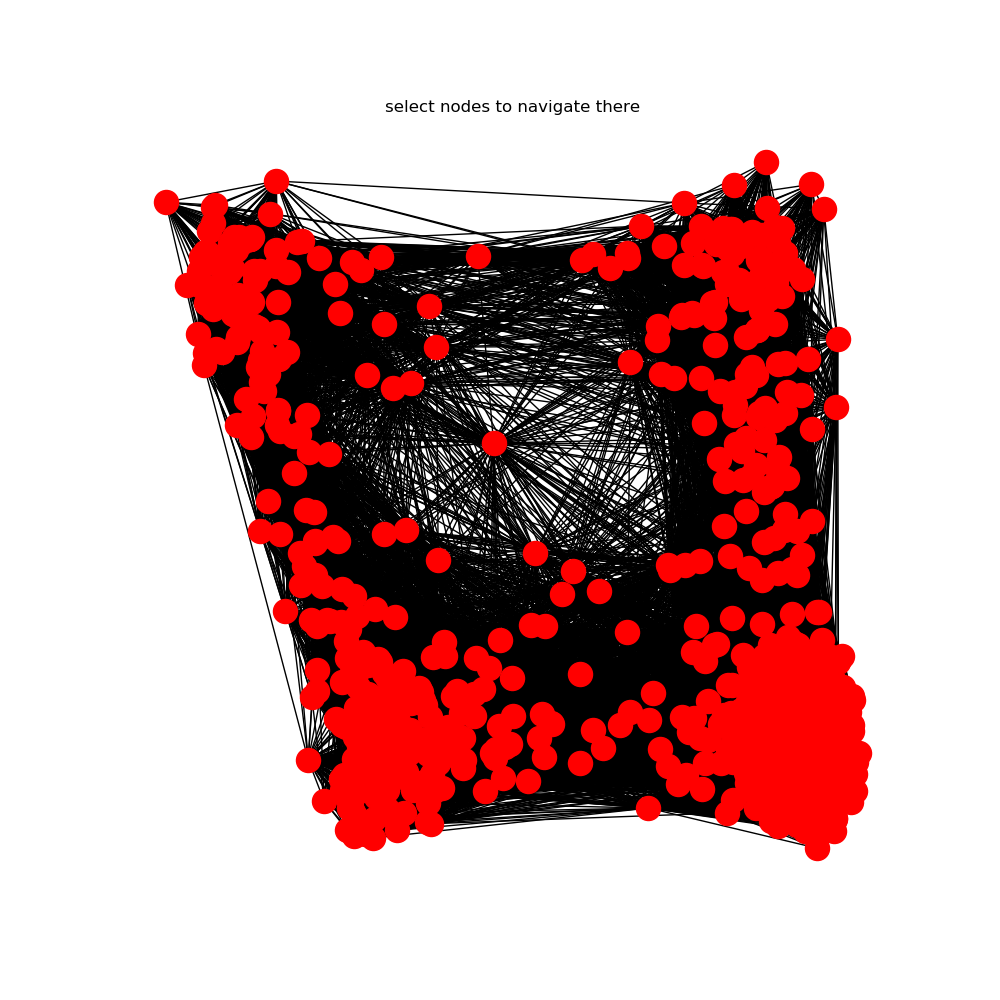

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('select nodes to navigate there')

x,y,annotes=[],[],[]

for key in pos:
    d=pos[key]
    annotes.append(key)
    x.append(d[0])
    y.append(d[1])

nx.draw(G,pos,font_size=8)

af = AnnoteFinder(x,y, annotes)
fig.canvas.mpl_connect('button_press_event', af)

plt.show()